In [ ]:
# Estimates the error introduced when statistics are only available at LSOA level,
# compared to OA level.
#
# Relies on:
# - boundary files for 2011 census OA/LSOA
# - boundary files for new 2022 wards
# - 20xx population estimate, generated by "lbl_data_pop_est.ipynb"

In [34]:
# Dependencies
!pip install geopandas mapclassify

In [2]:
import os

import geopandas as gpd
import mapclassify
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive

Data
==


GDrive mount
--

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [115]:
project_dir = '/content/gdrive/MyDrive/WardProfiles'
oa_dir = f"{project_dir}/boundaries/oa"
ward_dir = f"{project_dir}/boundaries/2022_wards"
oa_lookups_dir = f"{project_dir}/lookups/oa"
ward_lookups_dir = f"{project_dir}/lookups/2022_wards"
population_dir = f"{project_dir}/population"

# Output for maps
out_dir = f"{project_dir}/maps/2022_wards/classification_error"

In [116]:
!mkdir -p "{out_dir}"

In [6]:
!ls -lh "{oa_dir}"/lbl_*oa*.gpkg

-rw------- 1 root root 152K Nov  1 13:41 /content/gdrive/MyDrive/WardProfiles/boundaries/oa/lbl_lsoa11_200m.gpkg
-rw------- 1 root root 216K Nov  1 13:41 /content/gdrive/MyDrive/WardProfiles/boundaries/oa/lbl_lsoa11_20m.gpkg
-rw------- 1 root root 120K Nov  1 13:41 /content/gdrive/MyDrive/WardProfiles/boundaries/oa/lbl_lsoa11_centroids.gpkg
-rw------- 1 root root 1.5M Nov  1 13:41 /content/gdrive/MyDrive/WardProfiles/boundaries/oa/lbl_lsoa11_full.gpkg
-rw------- 1 root root 108K Nov  1 13:41 /content/gdrive/MyDrive/WardProfiles/boundaries/oa/lbl_msoa11_200m.gpkg
-rw------- 1 root root 140K Nov  1 13:41 /content/gdrive/MyDrive/WardProfiles/boundaries/oa/lbl_msoa11_20m.gpkg
-rw------- 1 root root  96K Nov  1 13:41 /content/gdrive/MyDrive/WardProfiles/boundaries/oa/lbl_msoa11_centroids.gpkg
-rw------- 1 root root 756K Nov  1 13:41 /content/gdrive/MyDrive/WardProfiles/boundaries/oa/lbl_msoa11_full.gpkg
-rw------- 1 root root 420K Nov  1 13:41 /content/gdrive/MyDrive/WardProfiles/boundaries

In [7]:
!ls -lh "{ward_dir}"/lbl*.gpkg

-rw------- 1 root root 292K Nov  1 14:53 /content/gdrive/MyDrive/WardProfiles/boundaries/2022_wards/lbl_wd22_proposed.gpkg


In [8]:
!ls -lh "{oa_lookups_dir}"/lbl*

-rw------- 1 root root 87K Nov  2 14:04 /content/gdrive/MyDrive/WardProfiles/lookups/oa/lbl_oa11_lsoa11_msoa11_lad20_rgn20_202012.csv
-rw------- 1 root root 50K Nov  2 14:04 /content/gdrive/MyDrive/WardProfiles/lookups/oa/lbl_oa11_wd20_lad20_202012.csv


In [9]:
!ls -lh "{ward_lookups_dir}"/lbl*

-rw------- 1 root root 5.2K Nov  2 14:12 /content/gdrive/MyDrive/WardProfiles/lookups/2022_wards/lbl_lsoa11_wd22_proposed.csv
-rw------- 1 root root 1.2K Nov  2 14:12 /content/gdrive/MyDrive/WardProfiles/lookups/2022_wards/lbl_msoa11_wd22_proposed.csv
-rw------- 1 root root  28K Nov  2 14:11 /content/gdrive/MyDrive/WardProfiles/lookups/2022_wards/lbl_oa11_wd22_proposed.csv


In [10]:
!ls -lh "{population_dir}"/lbl*all*oa11.csv

-rw------- 1 root root  13K Nov  3 13:09 /content/gdrive/MyDrive/WardProfiles/population/lbl_pop_est_2020_5ybins_all_lsoa11.csv
-rw------- 1 root root  55K Nov  3 13:09 /content/gdrive/MyDrive/WardProfiles/population/lbl_pop_est_2020_5ybins_all_oa11.csv
-rw------- 1 root root  45K Nov  2 16:12 /content/gdrive/MyDrive/WardProfiles/population/lbl_pop_est_2020_all_lsoa11.csv
-rw------- 1 root root 175K Nov  2 16:12 /content/gdrive/MyDrive/WardProfiles/population/lbl_pop_est_2020_all_oa11.csv


OA/Ward geometry
--

In [11]:
# Ward22 geometry
wd22 = gpd.read_file(f"{ward_dir}/lbl_wd22_proposed.gpkg")
len(wd22)

19

In [12]:
# OA geometry
oa11 = gpd.read_file(f"{oa_dir}/lbl_oa11_20m.gpkg")
len(oa11)

887

In [13]:
# LSOA geometry
lsoa11 = gpd.read_file(f"{oa_dir}/lbl_lsoa11_20m.gpkg")
len(lsoa11)

169

Pop est
--

In [14]:
pe_oa = pd.read_csv(f"{population_dir}/lbl_pop_est_2020_all_oa11.csv")
pe_oa = pe_oa[pe_oa.columns[:2]] # No need to include age breakdowns
pe_oa = pe_oa.rename(columns={'All Ages': 'PopEst2020'})
print(len(pe_oa))
pe_oa.head()

887


,OA11CD,PopEst2020
0,E00016115,326
1,E00016136,314
2,E00016137,404
3,E00016138,295
4,E00016139,352


In [15]:
# # Join & dissolve
# lsoa_wards = lsoa11.merge(lsoa11_wd22, on='LSOA11CD').dissolve(by='WD22CD_proposed')

Error estimation
==

OA-LSOA-Ward mapping
--

In [16]:
# OA11-WD22 lookup table: the expected Ward assignment per OA
oa11_wd22 = pd.read_csv(f"{ward_lookups_dir}/lbl_oa11_wd22_proposed.csv")
oa11_wd22.head(2)

,OA11CD,WD22NM_proposed,WD22CD_proposed
0,E00016403,Evelyn,E05013721
1,E00016442,Evelyn,E05013721


In [17]:
# LSOA11-WD22 lookup table
lsoa11_wd22 = pd.read_csv(f"{ward_lookups_dir}/lbl_lsoa11_wd22_proposed.csv")
lsoa11_wd22.head(2)

,LSOA11CD,WD22NM_proposed,WD22CD_proposed
0,E01003316,Perry Vale,E05013729
1,E01003314,Perry Vale,E05013729


In [18]:
# Derive an OA11-LSOA11-WD22 lookup table: OA-Ward assignment if determined via LSOAs
oa11_lsoa11 = pd.read_csv(f"{oa_lookups_dir}/lbl_oa11_lsoa11_msoa11_lad20_rgn20_202012.csv")
# oa11_lsoa11 = oa11_lsoa11.set_index('OA11CD').LSOA11CD
oa11_lsoa11 = oa11_lsoa11[['OA11CD', 'LSOA11CD']]
# oa11_lsoa11 = oa11_lsoa11.to_dict()

oa11_lsoa11_wd22 = pd.merge(oa11_lsoa11, lsoa11_wd22, on='LSOA11CD')
oa11_lsoa11_wd22

,OA11CD,LSOA11CD,WD22NM_proposed,WD22CD_proposed
0,E00016277,E01003220,Hither Green,E05013724
1,E00016278,E01003220,Hither Green,E05013724
2,E00016285,E01003220,Hither Green,E05013724
3,E00016274,E01003220,Hither Green,E05013724
4,E00016276,E01003220,Hither Green,E05013724
...,...,...,...,...
882,E00016670,E01033320,Hither Green,E05013724
883,E00016671,E01033320,Hither Green,E05013724
884,E00016672,E01033320,Hither Green,E05013724
885,E00173708,E01033320,Hither Green,E05013724


Determine false ward assignments
---

In [19]:
# Put it all together
oa_wards = oa11_wd22.rename(columns={'WD22NM_proposed': 'ActualWardName', 'WD22CD_proposed': 'ActualWard'})
oa_wards = pd.merge(oa_wards, 
                    oa11_lsoa11_wd22.rename(columns={'WD22NM_proposed': 'AssignedWardName', 'WD22CD_proposed': 'AssignedWard'}),
                    on='OA11CD')
oa_wards['CorrectAssignment'] = oa_wards.ActualWard==oa_wards.AssignedWard
oa_wards = pd.merge(oa_wards, pe_oa, on='OA11CD') 
oa_wards.head()

,OA11CD,ActualWardName,ActualWard,LSOA11CD,AssignedWardName,AssignedWard,CorrectAssignment,PopEst2020
0,E00016403,Evelyn,E05013721,E01003244,Evelyn,E05013721,True,370
1,E00016442,Evelyn,E05013721,E01003244,Evelyn,E05013721,True,414
2,E00016407,Evelyn,E05013721,E01003248,Evelyn,E05013721,True,211
3,E00016404,Evelyn,E05013721,E01003247,Evelyn,E05013721,True,391
4,E00016402,Evelyn,E05013721,E01003248,Evelyn,E05013721,True,307


In [20]:
len(oa_wards), len(oa_wards[oa_wards.CorrectAssignment==False])

(887, 39)

In [122]:
oa_wards.to_csv(f"{out_dir}/lbl_lsoa11_wd22_oa_classification_error.csv", index=False)

OA gain/loss
--

In [21]:
ward_oa = oa_wards.groupby('AssignedWardName').OA11CD.nunique().rename('Number of OAs')
ward_oa

AssignedWardName
Bellingham          32
Blackheath          55
Brockley            68
Catford South       45
Crofton Park        46
Deptford            39
Downham             59
Evelyn              32
Forest Hill         51
Grove Park          49
Hither Green        59
Ladywell            37
Lee Green           44
Lewisham Central    16
New Cross Gate      32
Perry Vale          62
Rushey Green        57
Sydenham            54
Telegraph Hill      50
Name: Number of OAs, dtype: int64

In [22]:
# Breakdown by assigned ward: how many OAs does this ward erroneously receive on top of its existing OAs?
ward_oa_gain = oa_wards[oa_wards.CorrectAssignment==False].\
  groupby('AssignedWardName').AssignedWardName.count().\
  rename('OAs gained')
ward_oa_gain

AssignedWardName
Blackheath           1
Brockley            13
Catford South        2
Deptford             3
Downham              3
Evelyn               2
Hither Green         3
Lewisham Central     3
New Cross Gate       3
Perry Vale           2
Rushey Green         4
Name: OAs gained, dtype: int64

In [23]:
# Breakdown by actual ward: how many OAs end up with another ward?
ward_oa_loss = oa_wards[oa_wards.CorrectAssignment==False].\
  groupby('ActualWardName').ActualWardName.count().\
  rename('OAs lost')
ward_oa_loss

ActualWardName
Bellingham           2
Catford South        4
Deptford            10
Downham              1
Evelyn               3
Grove Park           1
Hither Green         4
Ladywell            11
Lewisham Central     1
Sydenham             2
Name: OAs lost, dtype: int64

Pop gain/loss
--

In [24]:
ward_pop = oa_wards.groupby('AssignedWardName').PopEst2020.sum().rename('PopEst2020')
ward_pop

AssignedWardName
Bellingham          10949
Blackheath          17492
Brockley            22638
Catford South       16850
Crofton Park        15539
Deptford            13254
Downham             18891
Evelyn              14040
Forest Hill         16314
Grove Park          15326
Hither Green        20459
Ladywell            12290
Lee Green           16080
Lewisham Central     9456
New Cross Gate      11192
Perry Vale          19814
Rushey Green        20475
Sydenham            16779
Telegraph Hill      17471
Name: PopEst2020, dtype: int64

In [25]:
# Breakdown by assigned ward: how many residents does this ward erroneously receive on top of its existing OAs?
ward_pop_gain = oa_wards[oa_wards.CorrectAssignment==False].\
  groupby('AssignedWardName').PopEst2020.sum().\
  rename('Pop. gained')
ward_pop_gain

AssignedWardName
Blackheath           338
Brockley            3989
Catford South        742
Deptford            1016
Downham              990
Evelyn               550
Hither Green        1078
Lewisham Central    1751
New Cross Gate      1499
Perry Vale           598
Rushey Green        1241
Name: Pop. gained, dtype: int64

In [26]:
# Breakdown by actual ward: how many residents end up with another ward?
ward_pop_loss = oa_wards[oa_wards.CorrectAssignment==False].\
  groupby('ActualWardName').PopEst2020.sum().\
  rename('Pop. lost')
ward_pop_loss

ActualWardName
Bellingham           733
Catford South       1354
Deptford            3379
Downham              323
Evelyn              1016
Grove Park           391
Hither Green        1250
Ladywell            4410
Lewisham Central     338
Sydenham             598
Name: Pop. lost, dtype: int64

Summary table
--

In [118]:
d = pd.DataFrame(index=wd22.WD22NM_proposed.sort_values().rename('2022 Ward')).\
  join(ward_oa).\
  join(ward_oa_gain).\
  join(ward_oa_loss).\
  join(ward_pop).\
  join(ward_pop_gain).\
  join(ward_pop_loss).\
  fillna(0).astype(int)
d['% pop. error'] = ((d['Pop. gained'] + d['Pop. lost']) * 100. / d.PopEst2020).round(1)

In [119]:
d.to_csv(f"{out_dir}/lbl_lsoa11_wd22_ward_classification_error.csv", index=True)

In [28]:
int_format = "{:,}"
float_format = "{:.1f} %"
d.style.format(formatter={
    'PopEst2020': int_format, 
    'Pop. gained': int_format, 
    'Pop. lost': int_format,
    '% pop. error': float_format
})

,Number of OAs,OAs gained,OAs lost,PopEst2020,Pop. gained,Pop. lost,% pop. error
2022 Ward,,,,,,,
Bellingham,32,0,2,"10,949",0,733,6.7 %
Blackheath,55,1,0,"17,492",338,0,1.9 %
Brockley,68,13,0,"22,638","3,989",0,17.6 %
Catford South,45,2,4,"16,850",742,"1,354",12.4 %
Crofton Park,46,0,0,"15,539",0,0,0.0 %
Deptford,39,3,10,"13,254","1,016","3,379",33.2 %
Downham,59,3,1,"18,891",990,323,7.0 %
Evelyn,32,2,3,"14,040",550,"1,016",11.2 %
Forest Hill,51,0,0,"16,314",0,0,0.0 %


In [29]:
d['% pop. error'].describe()

count    19.000000
mean      9.900000
std      10.747558
min       0.000000
25%       2.250000
50%       6.700000
75%      12.900000
max      35.900000
Name: % pop. error, dtype: float64

Maps
==

In [32]:
oa11_error = oa11.merge(oa_wards[['OA11CD', 'CorrectAssignment', 'PopEst2020']], on='OA11CD')
oa11_error.head()

,OBJECTID,OA11CD,LAD11CD,Shape__Are,Shape__Len,geometry,CorrectAssignment,PopEst2020
0,15702,E00016112,E09000023,18660.395157,704.571923,"POLYGON ((536757.253 172734.038, 536762.216 17...",True,341
1,15703,E00016113,E09000023,117593.020729,2168.060859,"POLYGON ((537785.395 172279.387, 537869.413 17...",True,394
2,15704,E00016114,E09000023,32929.394821,1265.176677,"POLYGON ((537280.390 172157.386, 537246.836 17...",True,310
3,15705,E00016115,E09000023,39160.222458,1148.010919,"POLYGON ((537277.146 171847.804, 537371.767 17...",True,326
4,15706,E00016116,E09000023,48012.147423,1045.653029,"POLYGON ((536720.000 171753.000, 536786.536 17...",True,389


In [53]:
len(oa11_error), len(oa11_error[oa11_error.CorrectAssignment==True]), len(oa11_error[oa11_error.CorrectAssignment==False])

(887, 848, 39)

Spatial error
--

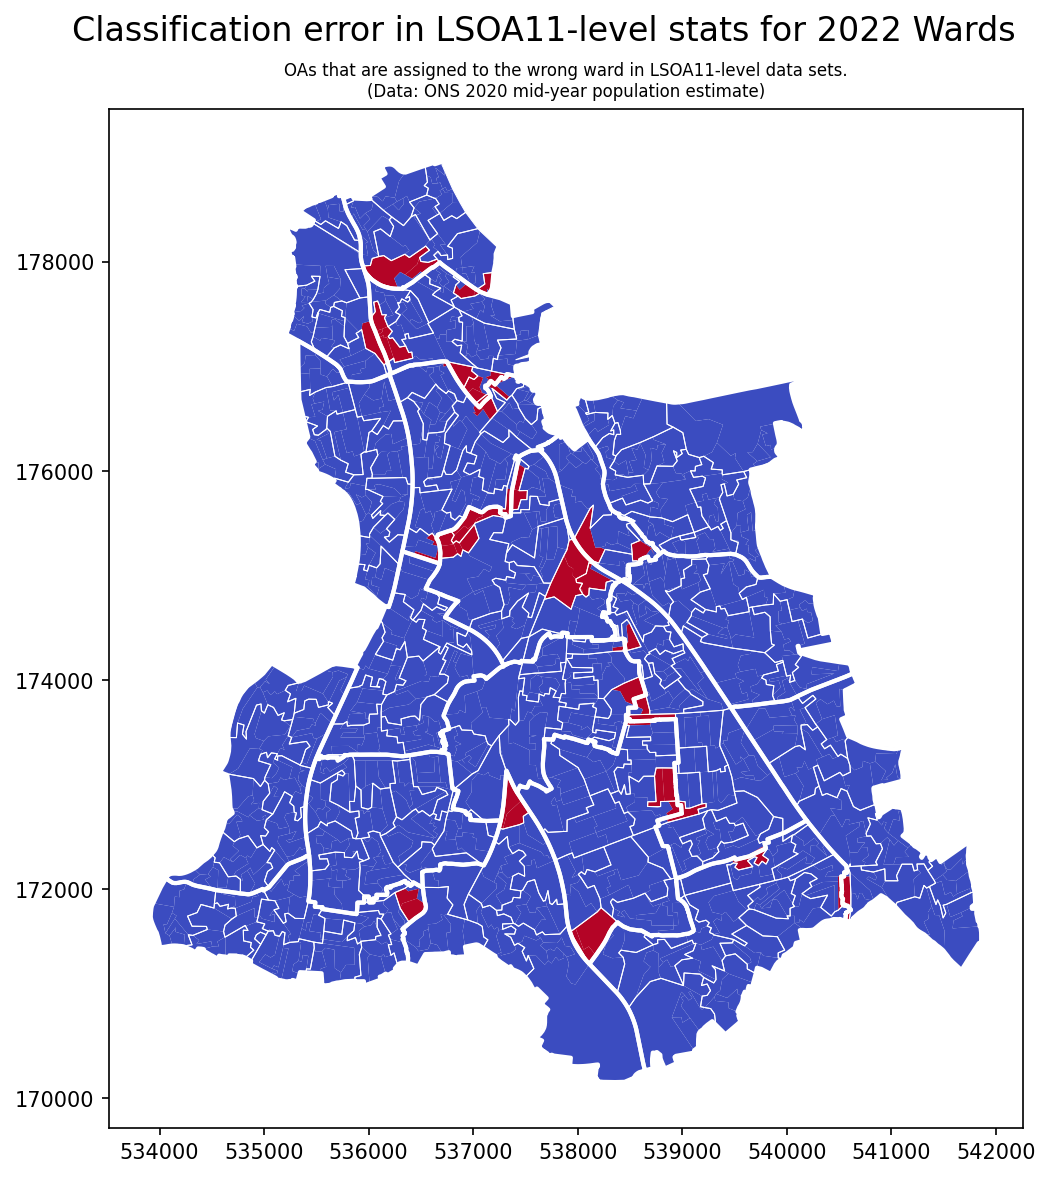

In [120]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=150)
plt.suptitle('Classification error in LSOA11-level stats for 2022 Wards', fontsize=16, y=.95)
plt.title('OAs that are assigned to the wrong ward in LSOA11-level data sets.\n(Data: ONS 2020 mid-year population estimate)', fontsize=8)

oa11_error.plot(ax=ax, column='CorrectAssignment',
                cmap='coolwarm_r', # Red to blue
                legend=False) 
# oa11.plot(ax=ax, facecolor='none', linewidth=0.5, edgecolor='white', alpha=0.5)
lsoa11.plot(ax=ax, facecolor='none', linewidth=0.5, edgecolor='white')
wd22.plot(ax=ax, facecolor='none', linewidth=2, edgecolor='white')
# plt.legend()

plt.savefig(f"{out_dir}/lbl_lsoa11_wd22_ward_classification_error.png", dpi=600)
plt.savefig(f"{out_dir}/lbl_lsoa11_wd22_ward_classification_error.pdf")

Population error
--

In [81]:
import matplotlib.cm
import matplotlib.colors
import numpy as np

# Custom palettes: don't start at white
min_cmap_idx = 0.4
blues = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap('Blues')(np.linspace(min_cmap_idx, 1, 256)))
reds = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap('Reds')(np.linspace(min_cmap_idx, 1, 256)))

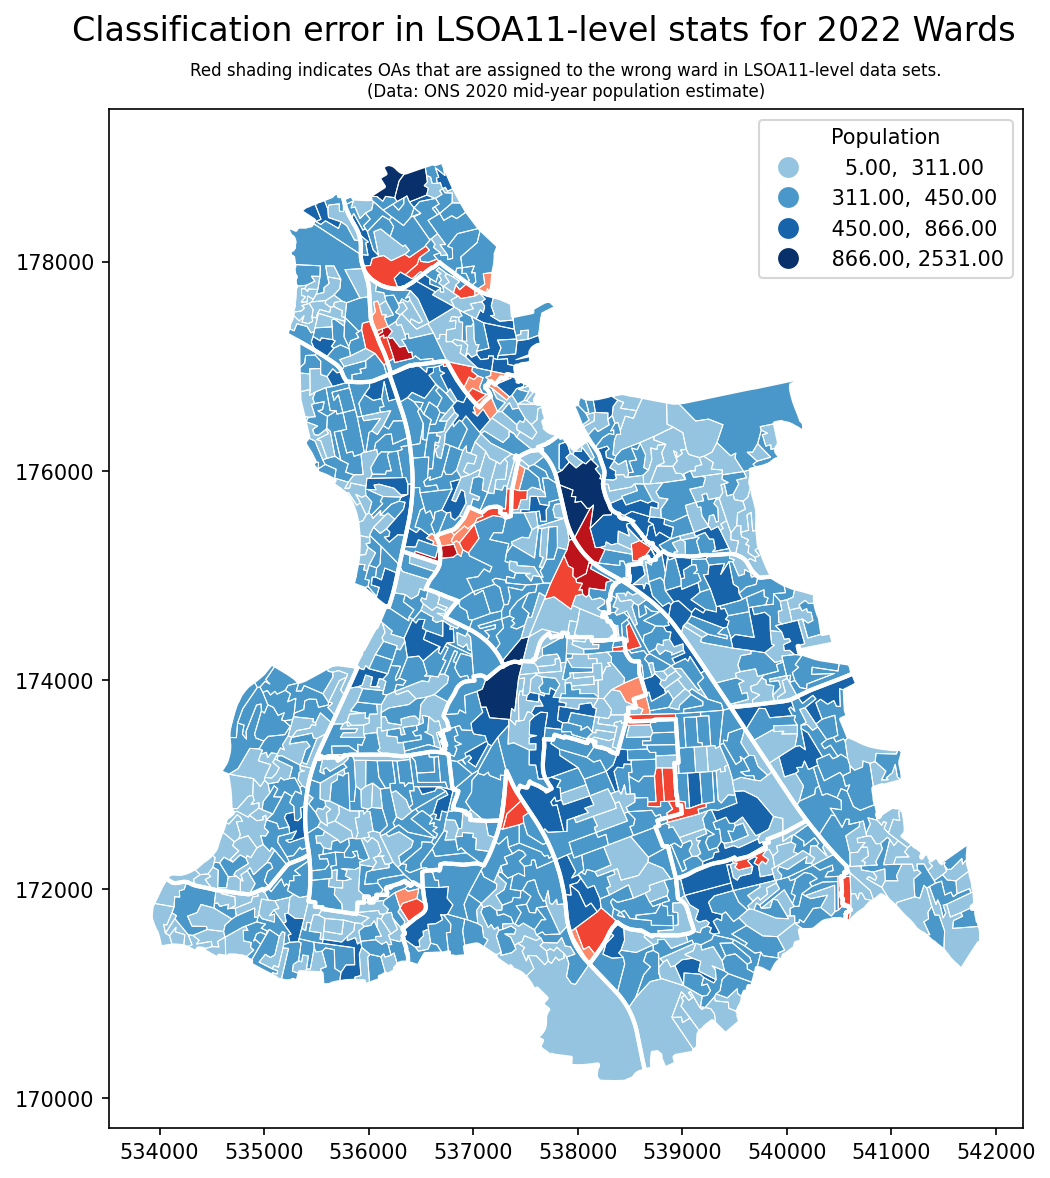

In [121]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=150)
plt.suptitle('Classification error in LSOA11-level stats for 2022 Wards', fontsize=16, y=.95)
plt.title('Red shading indicates OAs that are assigned to the wrong ward in LSOA11-level data sets.\n(Data: ONS 2020 mid-year population estimate)', fontsize=8)

# First determine our breaks -- this will be shared by the two plots
breaks = mapclassify.NaturalBreaks(oa11_error.PopEst2020, k=4)
oa11_error[oa11_error.CorrectAssignment==True].plot(ax=ax, column='PopEst2020',
                # mapclassify parameters for breaks
                # See https://pysal.org/mapclassify/api.html
                scheme='user_defined', 
                classification_kwds={
                   'bins': breaks.bins,
                },
                cmap=blues,#'Blues',
                legend=True,
                legend_kwds={
                    'title': 'Population'
                }) 
oa11_error[oa11_error.CorrectAssignment==False].plot(ax=ax, column='PopEst2020',
                scheme='user_defined', 
                classification_kwds={
                   'bins': breaks.bins,
                },
                cmap=reds,#'Reds',
                legend=False) 
oa11.plot(ax=ax, facecolor='none', linewidth=0.5, edgecolor='white')
# lsoa11.plot(ax=ax, facecolor='none', linewidth=0.5, edgecolor='black')
wd22.plot(ax=ax, facecolor='none', linewidth=2, edgecolor='white')
# plt.legend()

plt.savefig(f"{out_dir}/lbl_lsoa11_wd22_ward_classification_impact.png", dpi=600)
plt.savefig(f"{out_dir}/lbl_lsoa11_wd22_ward_classification_impact.pdf")